In [1]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import functools

/home/krisztina/Documents/MLMI/Advanced_ML/BayesianFLowNetworks/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [99]:

from torch.utils.tensorboard import SummaryWriter

class BayesianFlowNetworkDiscretized(nn.Module):
    """
    Bayesian Flow Network for discretized data.
    
    Parameters:
    D (int): dimensionality of data
    K (int): number of classes
    network: network used for predictions for p_output
    beta1 (float): initial beta parameter
    """
    def __init__(self, D=1, K=16, model=None, sigma_1=1e-3, device='cpu'):
        super(BayesianFlowNetworkDiscretized, self).__init__()
        self.D = D
        self.K = K # num_bins
        self.sigma_1 = sigma_1
        self.bin_width = 2.0 / K
        self.half_bin_width = self.bin_width / 2.0
        self.t_min = 1e-6
        self.model = model
        self.k_centres = torch.arange(self.half_bin_width - 1, 1, self.bin_width) # (K,)
        self.k_lefts = self.k_centres - 1/self.K # (K,)
        self.k_rights = self.k_centres + 1/self.K # (K,)

    
    def get_gamma(self, t:Tensor):
        return 1 - self.sigma_1**(2 * t)


    def forward(self, mu:Tensor, t:Tensor) -> tuple[Tensor]:
        mu = (mu * 2) - 1 # rescale to [-1, 1] to have distribution centered around 0 # (B, D)
        #print(f'mu.shape = {mu.shape}')
        input_ = torch.cat([mu, t.unsqueeze(-1)], dim=-1) # (B, D + 1)
        #print(f'input_.shape = {input_.shape}')
        output = self.model(input_) # (B, D * 2) mu and log sigma assume the net learns this 
        output =  output.view(output.shape[0], self.D, -1) # (B, D, 2)
        mu_e = output[:, :, 0] # (B, D)
        log_sigma_e = output[:, :, 1] # (B, D)
        return mu_e, log_sigma_e
        

    def discretised_cdf(self, mu, sigma, x):
        """
        Compute the CDF of the discretised output distribution.
        params:
        mu (torch.Tensor): mean of the output distribution. Shape (B)
        sigma: standard deviation of the output distribution Shape (B)
        x: the input value Shape (B,)
        return:
        G: the CDF of the discretised output distribution. Shape (B)
        """
        # CDF
        F_x = 0.5 * (1 + torch.erf((x - mu)/ (sigma* torch.sqrt(torch.tensor(2.0))) )) # (B,)

        # Clipped CDF for d = 1, kc
        G = torch.where(x<=-1, torch.zeros_like(mu), torch.where(x>=1, torch.ones_like(mu), F_x) ) # (B,)
        return G


    def discretised_output_distribution(self, mu:Tensor, t:Tensor, K:int, gamma:Tensor):
        # if t<self.t_min:
        #     mu_x = torch.zeros_like(mu)
        #     sigma_x = torch.ones_like(mu)
        # else:
        #     mu_e, log_sigma_e = self.forward(mu, t)  # (B, D), (B, D)
            
        #     mu_x = mu/gamma + torch.sqrt((1 - gamma) / gamma)*mu_e  # (B, D)
        #     sigma_x = torch.sqrt((1 - gamma) / gamma)*np.exp(log_sigma_e)  # (B, D)

        mu_e, log_sigma_e = self.forward(mu, t)  # (B, D), (B, D)
        print(f'mu_e.shape = {mu_e.shape}')
        print(f'log_sigma_e.shape = {log_sigma_e.shape}')

        mu_x = torch.where(t.unsqueeze(-1) < self.t_min, torch.zeros_like(mu), 
                                                         mu / gamma + torch.sqrt((1 - gamma) / gamma) * mu_e)  # (B, D)
        sigma_x = torch.where(t.unsqueeze(-1) < self.t_min, torch.ones_like(mu), 
                                                            torch.sqrt((1 - gamma) / gamma) * torch.exp(log_sigma_e))  # (B, D)

        p_output = torch.zeros((mu_x.shape[0], self.D, self.K), device=mu_x.device, dtype=mu_x.dtype)  # (B, D, K)
        for d in range(self.D):
            for i in range(self.K):
                kl = self.k_lefts[i]
                kr = self.k_rights[i]
                
                p = self.discretised_cdf(mu_x[:, d], sigma_x[:, d], kr) - self.discretised_cdf(mu_x[:, d], sigma_x[:, d], kl)
                p_output[:, d, i] = p
                 
        return p_output # (B, D, K)


    def training_continuous_loss(self, x:torch.Tensor):
        #print(f'x.shape = {x.shape}')
        B = x.shape[0]

        # Sample t~U(0, 1)
        t = torch.rand((B,), device=x.device, dtype=torch.float32) # (B,)
        #print(t.shape)
        gamma = self.get_gamma(t) # (B,)
        #print(gamma.shape)

        # sample from sender distribution Ps(x*gamma, gamma(1-gamma)* I)
        mu = torch.distributions.Normal(x*gamma.unsqueeze(-1), gamma.unsqueeze(-1)*(1-gamma.unsqueeze(-1))).sample() # (B, D) 
        #print(f'mu.shape = {mu.shape}')

        # calculate the output distribution
        p_output = self.discretised_output_distribution(mu, t, self.K, gamma) # (B, D, K)
        print(f'p_output.shape = {p_output.shape}')

        # calculate the receiver distribution k_hat
        k_hat = torch.sum(p_output*self.k_centres, dim=-1) # (B, D)
        print(f'k_hat.shape = {k_hat.shape}')

        # calculate the KL divergence for continuous loss
        Loss_infinity = - np.log(self.sigma_1) * (self.sigma_1**(2*t)) * ((x-k_hat)**2) # (B, D)

        loss = torch.mean(Loss_infinity)
        return loss
    
    @torch.inference_mode()
    def sample(self, batch_size:int, n_steps:int):
        mu = torch.zeros((batch_size, self.D), dtype=torch.float32)
        ro = 1
        for i in range(n_steps):
            t = (i - 1)/n_steps
            t = t * torch.ones((mu.shape[0],), dtype=mu.dtype) # (batch_size,)
            gamma = self.get_gamma(t) # (batch_size,)
            p_output = self.discretised_output_distribution(mu, t, self.K, gamma) # (B, D, K)

            alpha = (self.sigma_1**(-2*i/n_steps)) * (1 - self.sigma_1**(2/n_steps)) # (B,)

            k_hat = torch.sum(p_output*self.k_centres, dim=-1) # (B, D)
            # sample from receiver distribution
            y = torch.distributions.Normal(k_hat, alpha).sample()

            # update mu
            mu = ((mu * ro) + (alpha * y))/(ro + alpha)
            # update ro
            ro = ro + alpha

        t_ones = torch.ones((mu.shape[0],), dtype=mu.dtype)
        p_output = self.discretised_output_distribution(mu, t_ones, self.K, gamma) # (B, D, K)
        k_hat = torch.sum(p_output*self.k_centres, dim=-1) # (B, D)
        return k_hat


In [103]:
def get_model(D, K, output_classes=2, hidden_dim=256):
    model = nn.Sequential(
            nn.Linear(D + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, D * output_classes)
            )
    return model

In [104]:
def generate_gaussian_mixture(n_samples, means, stds, weights, num_bins, device='cpu'):
    data = np.zeros((n_samples, 1))
    mode_indices = np.random.choice(len(means), size=n_samples, p=weights)
    
    for i, mode_idx in enumerate(mode_indices):
        data[i] = np.random.normal(means[mode_idx], stds[mode_idx])
    
    bins = np.linspace(-1, 1, num_bins)
    digitized = np.digitize(data, bins) - 1
    digitized = np.clip(digitized, 0, num_bins - 1)
    
    digitized = (digitized / (num_bins - 1)) * 2 - 1  # Scale the digitized values to [-1, 1]
    
    return torch.Tensor(digitized, device=device)
    


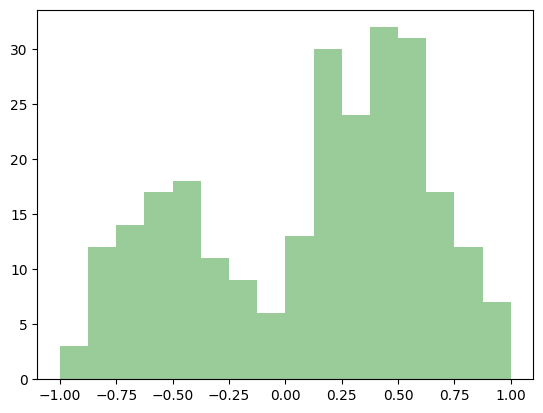

In [105]:
def plot_gaussian_mixture(means, stds, weights, num_bins, n_samples):
    data = generate_gaussian_mixture(n_samples, means, stds, weights, num_bins).to('cpu').numpy()
    plt.hist(data, bins=num_bins,  alpha=0.4, color='g')
    plt.show()

np.random.seed(42)
plot_gaussian_mixture(means=[-0.5, 0.5], stds=[0.2, 0.3], weights=[0.3, 0.7], num_bins=16, n_samples=256)

In [106]:
import torch
from torch.utils.data import Dataset, DataLoader

class GaussianMixtureDataset(Dataset):
    def __init__(self, n_samples, means, stds, weights, num_bins, device='cpu'):
        self.data = generate_gaussian_mixture(n_samples, means, stds, weights, num_bins, device=device)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
batch_size = 128
n_samples = 10000
means = [-0.5, 0.5]
stds = [0.2, 0.3]
weights = [0.3, 0.7]
num_bins = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = GaussianMixtureDataset(n_samples, means, stds, weights, num_bins, device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the model
model = get_model(D=1, K=16, output_classes=2, hidden_dim=128)
bfn = BayesianFlowNetworkDiscretized(D=1, K=16, model=model, sigma_1=1e-3, device=device)
bfn.to(device)

optimizer = torch.optim.AdamW(bfn.parameters(), lr=1e-3)

num_epochs=10
losses=[]
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        # Zero the gradients
        optimizer.zero_grad()

        # forward pass
        loss = bfn.training_continuous_loss(batch)

        # backward pass
        loss.backward()

        #update weights
        optimizer.step()

        losses.append(loss.item())
        total_epoch_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_epoch_loss/len(dataloader):.4f}")


    

mu_e.shape = torch.Size([128, 1])
log_sigma_e.shape = torch.Size([128, 1])
p_output.shape = torch.Size([128, 1, 16])
k_hat.shape = torch.Size([128, 1])
mu_e.shape = torch.Size([128, 1])
log_sigma_e.shape = torch.Size([128, 1])
p_output.shape = torch.Size([128, 1, 16])
k_hat.shape = torch.Size([128, 1])
mu_e.shape = torch.Size([128, 1])
log_sigma_e.shape = torch.Size([128, 1])
p_output.shape = torch.Size([128, 1, 16])
k_hat.shape = torch.Size([128, 1])
mu_e.shape = torch.Size([128, 1])
log_sigma_e.shape = torch.Size([128, 1])
p_output.shape = torch.Size([128, 1, 16])
k_hat.shape = torch.Size([128, 1])
mu_e.shape = torch.Size([128, 1])
log_sigma_e.shape = torch.Size([128, 1])
p_output.shape = torch.Size([128, 1, 16])
k_hat.shape = torch.Size([128, 1])
mu_e.shape = torch.Size([128, 1])
log_sigma_e.shape = torch.Size([128, 1])
p_output.shape = torch.Size([128, 1, 16])
k_hat.shape = torch.Size([128, 1])
mu_e.shape = torch.Size([128, 1])
log_sigma_e.shape = torch.Size([128, 1])
p_output.shap

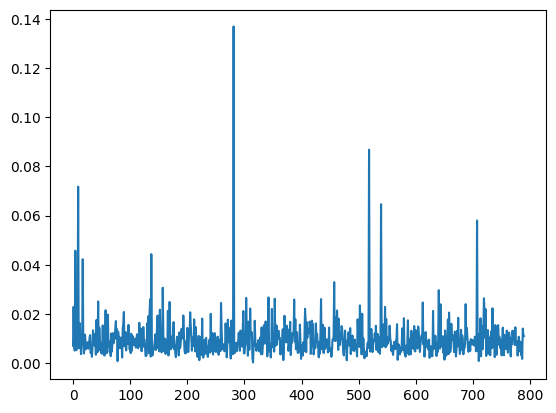

In [108]:
plt.plot(losses)

In [94]:
x_hat = bfn.sample(batch_size=128, n_steps=100).cpu().numpy()

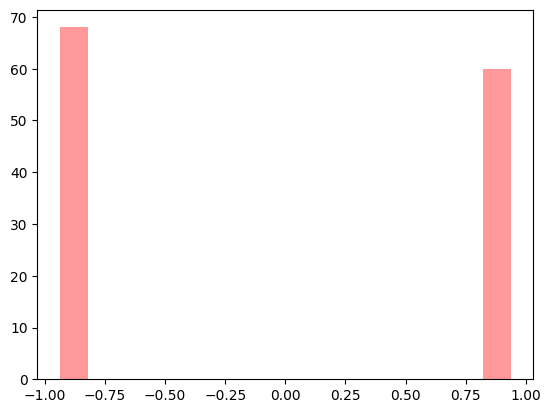

In [95]:
plt.hist(x_hat, bins=num_bins,  alpha=0.4, color='r')
plt.show()

In [52]:
generate_gaussian_mixture(n_samples, means, stds, weights, 3).shape

torch.Size([1000, 1])

In [10]:
mu = torch.Tensor([0.5, 0.5, 0.5])
sigma=0.1
x=torch.Tensor([-1, 0, 1])

# CDF
F_x = 0.5 * (1 + torch.erf((x - mu)/ (sigma* torch.sqrt(torch.Tensor([2.0]))) )) 
print(F_x)
print(F_x.shape)

# Clipped CDF
G = torch.where(x<=-1, torch.zeros_like(mu), torch.where(x>=1, torch.ones_like(mu), F_x) ) # B x D x K
print(G)
print(G.shape)


tensor([0.0000e+00, 2.9802e-07, 1.0000e+00])
torch.Size([3])
tensor([0.0000e+00, 2.9802e-07, 1.0000e+00])
torch.Size([3])


In [ ]:
cts_dist = torch.distributions.Normal(mean.squeeze(-1), std_dev.squeeze(-1), validate_args=False),

In [12]:
from torch.distributions.mixture_same_family import MixtureSameFamily
mix = torch.distributions.Categorical(torch.ones(5,))
comp = torch.distributions.Normal(torch.randn(5,), torch.rand(5,))
gmm = MixtureSameFamily(mix, comp)

In [4]:
gamma1 = 1 - 0.001**(2*0.01)
print(gamma1)
print(gamma1*(1-gamma1))
gamma2 = 1 - 0.001**(2*1)
print(gamma2)
print(gamma2*(1-gamma2))

0.12903641004391941
0.11238601492689691
0.999999
9.999990000287556e-07


In [19]:

mu = torch.Tensor([[0.1, 0.6, 0.5], 
                   [0.1, 0.7, 0.9]])
t = torch.Tensor([0.0, 1])

torch.where(t.unsqueeze(-1) < 1e-6, torch.zeros_like(mu), mu)

tensor([[0.0000, 0.0000, 0.0000],
        [0.1000, 0.7000, 0.9000]])